**Author: Petr Nguyen**

***Collaborators: Lukas Dolezal, Patrik Korsch, Roman Pavlata, Daniel Bihany***

In [42]:
import warnings
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from optbinning import BinningProcess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,precision_score, f1_score, recall_score, brier_score_loss, confusion_matrix
from scipy.stats import ks_2samp
import shap
from bayes_opt import BayesianOptimization

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 400)
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [43]:
def reading_data():
    """
    Function for reading the data from GitHub.
    """

    url_data = 'https://raw.githubusercontent.com/petr-ngn/Data_X_2022/main/data/mushrooms_vse.csv'
    data = pd.read_csv(url_data)

    #Converting object data types into categories for a faster comptutation.
    data = data.astype('category')
    return data

In [44]:
#All variables seem to be categorical
dataset = reading_data()
dataset

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8126,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8127,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8128,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8129,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


In [45]:
#There are no missing values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8131 entries, 0 to 8130
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   class                     8131 non-null   category
 1   cap-shape                 8131 non-null   category
 2   cap-surface               8131 non-null   category
 3   cap-color                 8131 non-null   category
 4   bruises                   8131 non-null   category
 5   odor                      8131 non-null   category
 6   gill-attachment           8131 non-null   category
 7   gill-spacing              8131 non-null   category
 8   gill-size                 8131 non-null   category
 9   gill-color                8131 non-null   category
 10  stalk-shape               8131 non-null   category
 11  stalk-root                8131 non-null   category
 12  stalk-surface-above-ring  8131 non-null   category
 13  stalk-surface-below-ring  8131 non-null   catego

In [46]:
#Other descriptive information such as number of unique values, the most frequent category and its frequency.
#The target variable (class) is dichotomous.
dataset.describe().transpose()

,count,unique,top,freq
class,8131,2,e,4211
cap-shape,8131,6,x,3663
cap-surface,8131,4,y,3244
cap-color,8131,10,n,2288
bruises,8131,2,f,4748
odor,8131,9,n,3528
gill-attachment,8131,2,f,7921
gill-spacing,8131,2,c,6819
gill-size,8131,2,b,5615
gill-color,8131,12,b,1728


In [47]:
#Unique categories for each variable.
for col in dataset.columns:
    print(col+':', list(dataset[col].unique()))

class: ['p', 'e']
cap-shape: ['x', 'b', 's', 'f', 'k', 'c']
cap-surface: ['s', 'y', 'f', 'g']
cap-color: ['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r']
bruises: ['t', 'f']
odor: ['p', 'a', 'l', 'n', 'f', 'c', 'y', 's', 'm']
gill-attachment: ['f', 'a']
gill-spacing: ['c', 'w']
gill-size: ['n', 'b']
gill-color: ['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o']
stalk-shape: ['e', 't', 'Ee']
stalk-root: ['e', 'c', 'b', 'r', '?']
stalk-surface-above-ring: ['s', 'f', 'k', 'y']
stalk-surface-below-ring: ['s', 'f', 'y', 'k']
stalk-color-above-ring: ['w', 'g', 'p', 'n', 'b', 'e', 'o', 'c', 'y']
stalk-color-below-ring: ['w', 'p', 'g', 'b', 'n', 'e', 'y', 'o', 'c']
veil-type: ['p']
veil-color: ['w', 'n', 'o', 'y']
ring-number: ['o', 't', 'n']
ring-type: ['p', 'e', 'l', 'f', 'n']
spore-print-color: ['k', 'n', 'u', 'h', 'w', 'r', 'o', 'y', 'b']
population: ['s', 'n', 'a', 'v', 'y', 'c']
habitat: ['u', 'g', 'm', 'd', 'p', 'w', 'l']


In [48]:
def removing_duplicates(data):
    """
    Function for printing the number of duplicated rows, which also return a data frame without any duplicates.
    """

    print(data.duplicated().sum(), 'duplicated rows.')
    
    return data[~data.duplicated()]

In [49]:
dataset = removing_duplicates(dataset)
dataset

6 duplicated rows.


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8126,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8127,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8128,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8129,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


In [50]:
#Data frame for storing the full names of variables' categories.
def reading_cats_names_kaggle():
    """
    Function for extracting and displaying full categories' names instead of their initials.
    This information was explicitly extracted from Kaggle and then uploaded to GitHub.
    """

    #Extracting the text from the txt file.
    url = "https://raw.githubusercontent.com/petr-ngn/Data_X_2022/main/data/category_names_kaggle.txt"
    page = requests.get(url)
    contents = page.text
    
    col_dict = {}

    #For each split row (where row has following format ... variable: full category name=initials of category name):
    for c in contents.split('\n'):
        cats_dict = {}
        #extracting column name
        col = c.split(':')[0]
        #extracting the categories' full names and their initials.
        cats_temp = c.split(':')[1].split(',')
        cats = []

        #For each pair full name category=category initials, split the full name and the initials from the strings.
        for cc in cats_temp:
            cats.append(cc.strip())

        #Separate both categories' full names and initials and assign to the new variables.
        cats_short = [i.split('=')[1] for i in cats]
        cats_full = [i.split('=')[0] for i in cats]

        #Storing the full name underneath the initial name:
        for k,v in zip(cats_short, cats_full):
            cats_dict[k] = v

        #Storing the full name-initials dictionary underneath the column dictionary.
        col_dict[col] = cats_dict

    df_col_desc = pd.DataFrame(columns = ['Initials','Full name'])

    #Storing the full names, initials with the variable names as row indices into a dataframe.
    for k in col_dict.keys():
        temp_df = pd.DataFrame(pd.Series(col_dict[k],index=col_dict[k].keys()),
                                columns = ['Full name']).reset_index().rename(columns = {'index':'Initials'})
        temp_df = temp_df.set_index(pd.Index([k for i in range(temp_df.shape[0])]))
        df_col_desc = pd.concat((df_col_desc, temp_df))

    return df_col_desc

In [51]:
category_names = reading_cats_names_kaggle()
category_names

,Initials,Full name
class,e,edible
class,p,poisonous
cap-shape,b,bell
cap-shape,c,conical
cap-shape,x,convex
...,...,...
habitat,m,meadows
habitat,p,paths
habitat,u,urban
habitat,w,waste


In [52]:
def mapping_cat_names(raw_data, cat_names_df):
    """
    Function for mapping the full categories' names to the initials.
    """

    data = raw_data.copy()

    for col in list(data.columns):
   
        data[col] = data[col].replace(list(cat_names_df.loc[col,'Initials']),
                                    list(cat_names_df.loc[col,'Full name']))
    return data


In [53]:
data_mapped = mapping_cat_names(dataset, category_names)
data_mapped

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8126,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8127,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,missing,smooth,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8128,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,missing,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8129,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,missing,smooth,silky,white,white,partial,white,one,evanescent,white,several,leaves


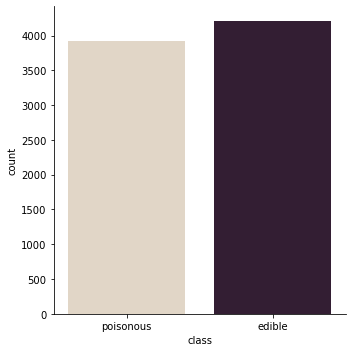

In [54]:
#Distribution of the target variable - the distribution seems almost uniform, therefore no under/oversampling is needed.
sns.catplot(data=data_mapped, x="class", kind="count", palette="ch:.25")
plt.show()

In [55]:
def feat_dist_plot(data, conditional = False):
    """
    Function for plotting the distribution of features.
    It can either display unconditional distribution or a distribution conditional on the target variable.
    """
    
    fig, axs = plt.subplots(nrows = 8, ncols = 3, figsize = (15, 35))
    for i, ax in zip(data.columns[data.columns != 'class'], axs.ravel()):
        sns.countplot(data = data, x=i ,ax = ax,hue= 'class' if conditional == True else None, palette = "ch:.25")
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, fontsize = 13)
        ax.set_title(i, fontsize = 15)
        ax.set(xlabel = None)

    for j in range(1,3):
        fig.delaxes(axs[7][j])

    fig.tight_layout()
    plt.show()

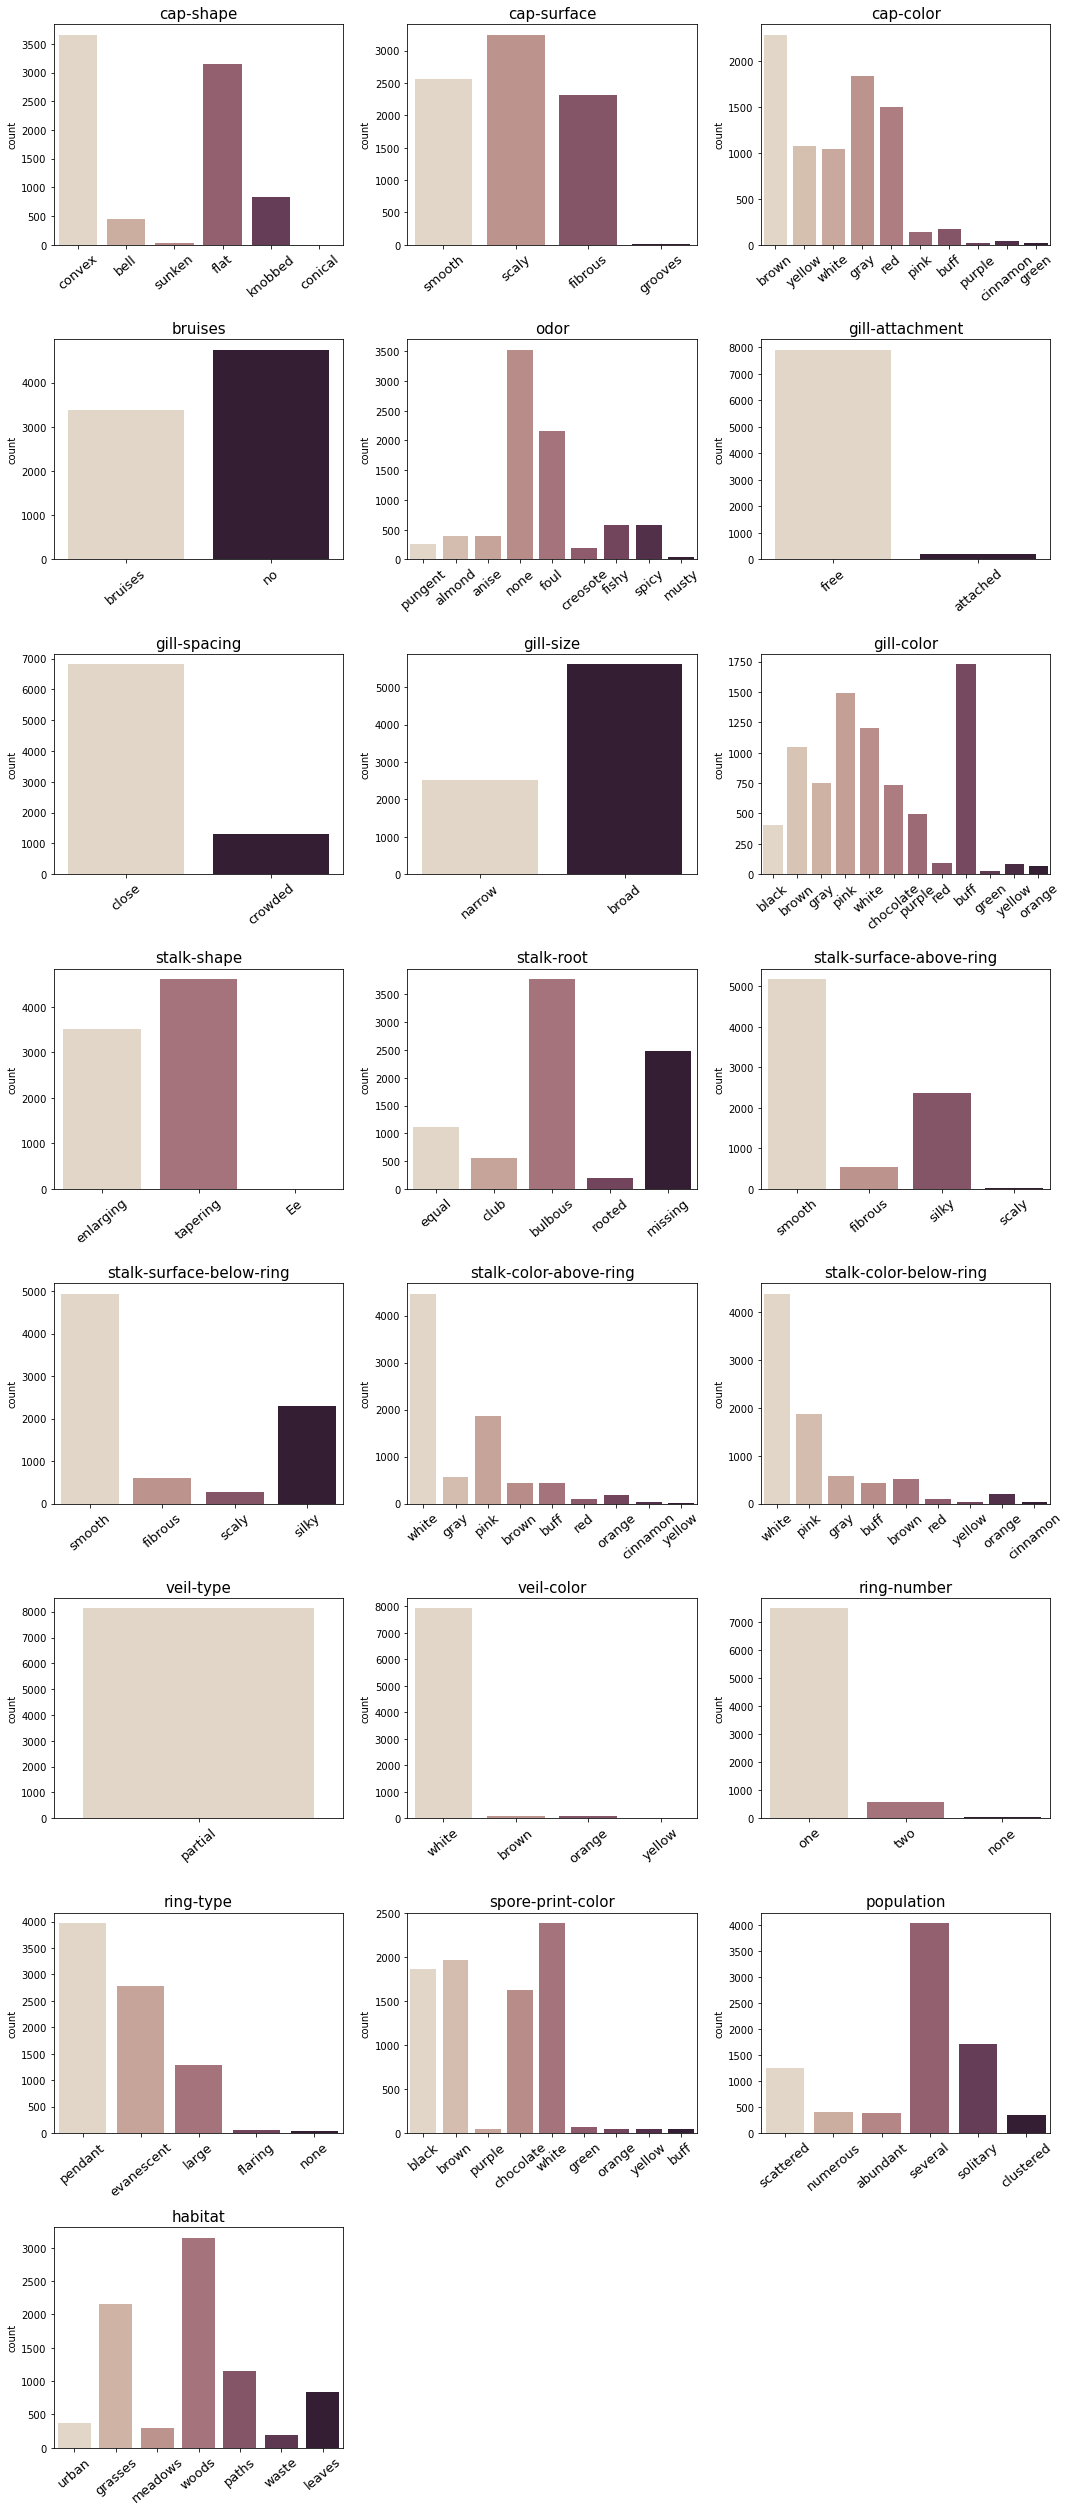

In [56]:
feat_dist_plot(data_mapped, conditional = False)

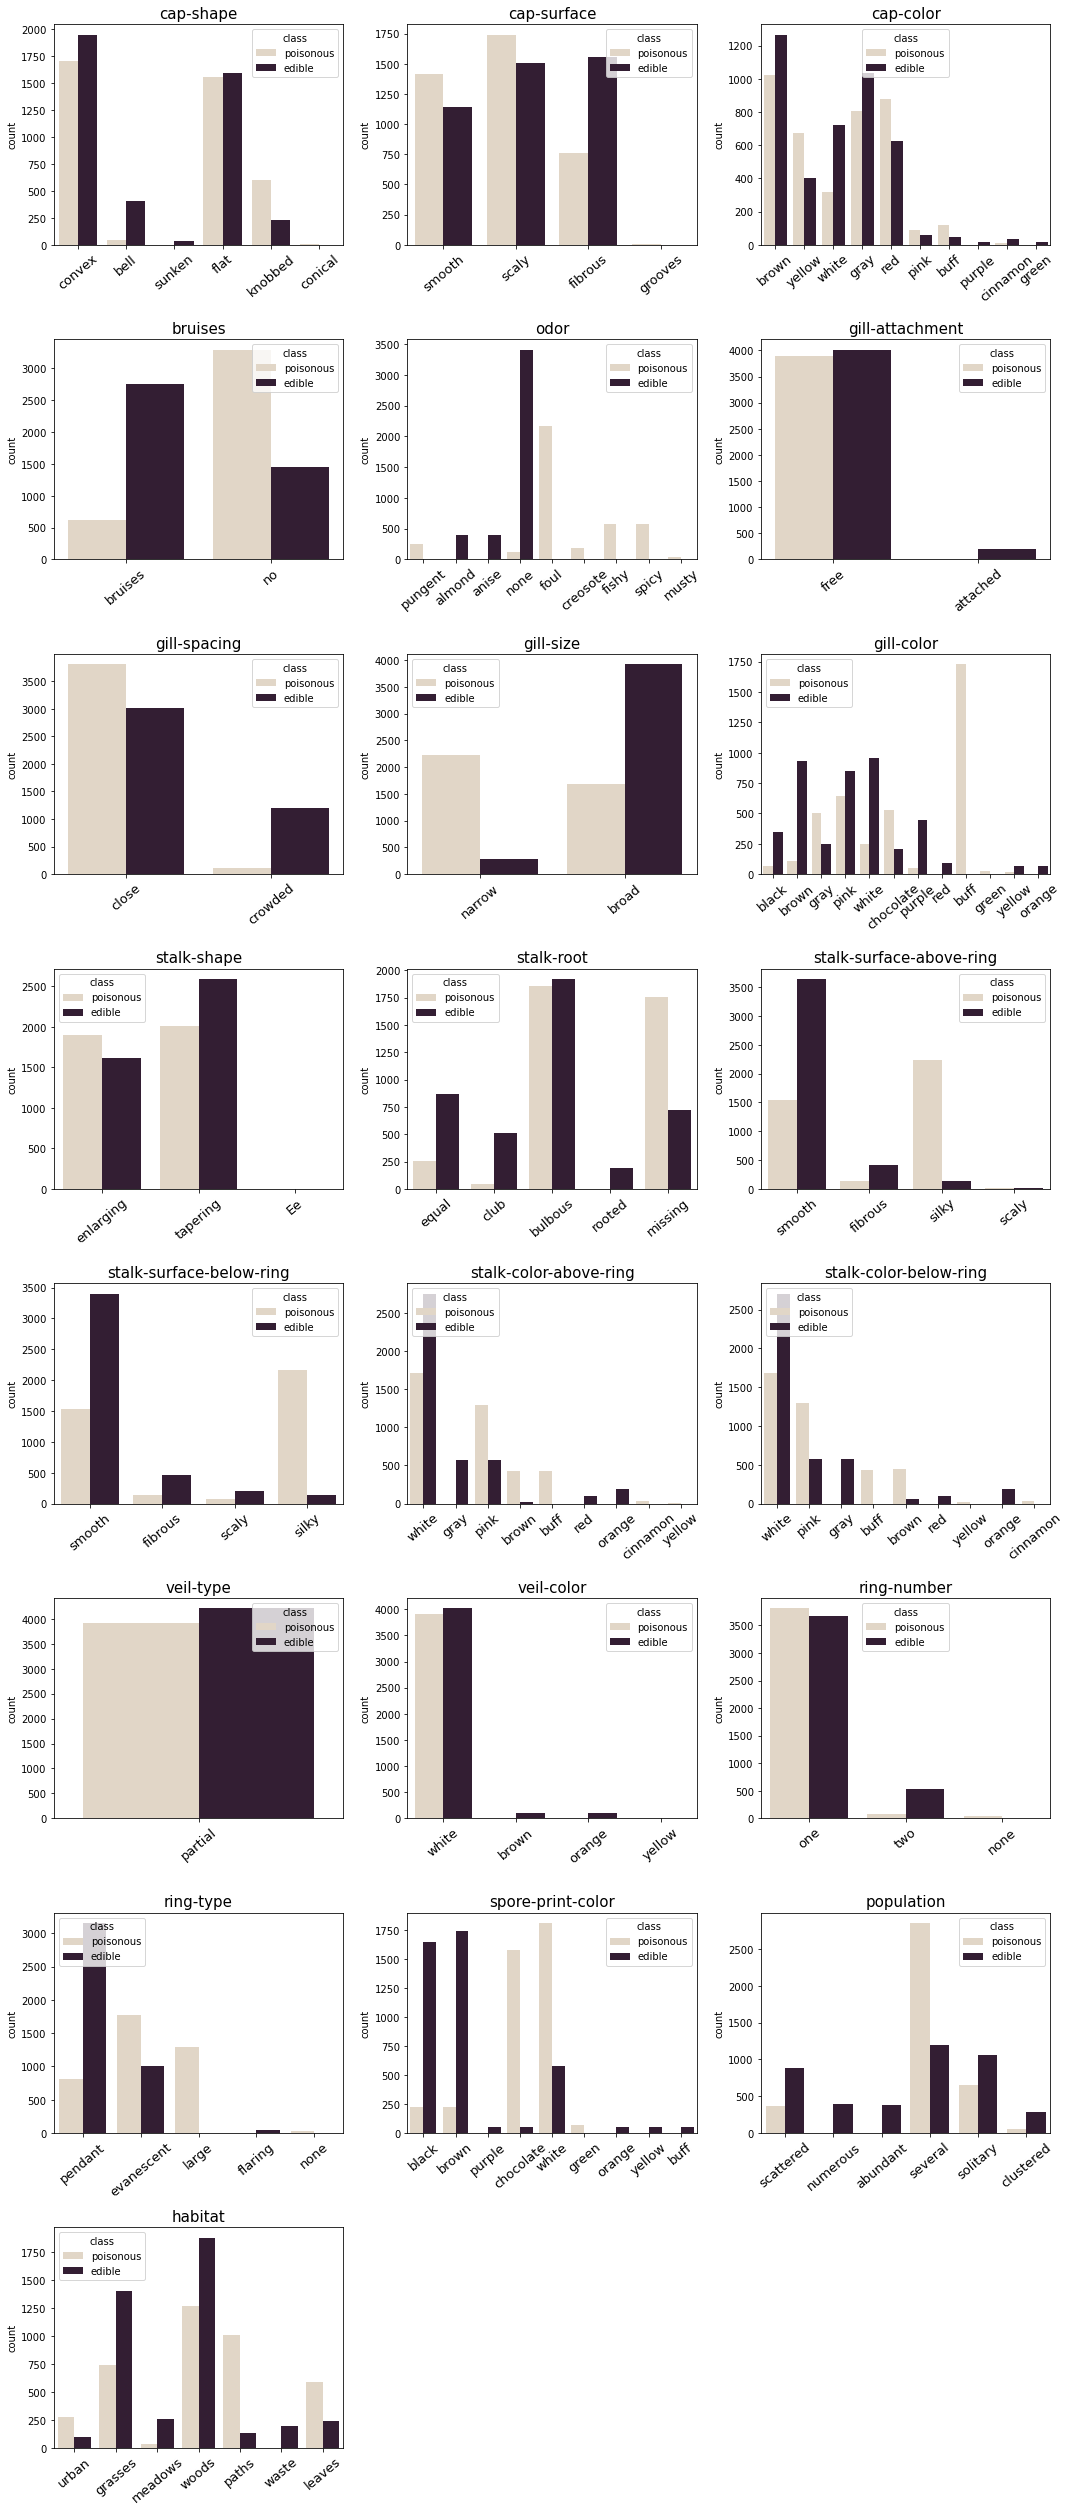

In [57]:
feat_dist_plot(data_mapped, conditional = True)

In [58]:
def data_split(data_to_split, valid = False):
    """
    Function for splitting the data into training, test and optionally validation set.
    Beforand the split, it first binarizes the target variable and then separates the target variable and features.
    """
    data = data_to_split.copy()

    #Constraints check:
    if valid not in [False, True]:
        raise ValueError('Only True or False Booleans are acceptable.')
    if type(data) != type(pd.DataFrame()):
        raise ValueError('The input data has to be a Data Frame type.')
    if 'class' not in data.columns:
        raise ValueError('The target variable has to be named as "class"')

    #Mapping the 'edible' or 'e' class as 1 and 'poisonous' or 'p' as 0 otherwise.    
    data['class'] = data['class'].apply(lambda x: 1 if re.search("e", x) != None else 0)

    Y = data['class']
    X = data.drop('class', axis = 1)

    seed = 702
    if valid:
        X_temp, X_test, y_temp, y_test = train_test_split(X,Y,stratify=Y,test_size=0.3,random_state=seed)
        X_train, X_valid, y_train, y_valid = train_test_split(X_temp,y_temp,stratify=y_temp,test_size=0.3,random_state=seed)

        return X_train, X_valid, X_test, y_train, y_valid, y_train

    else:
        
        return train_test_split(X,Y,stratify=Y,test_size=0.3,random_state=seed)

In [59]:
X_train, X_test, y_train, y_test = data_split(data_mapped)

In [60]:
def binning(x_train_set, y_train_labels, x_holdout_set, cat_vars):
    """
    Function for binning the variables optimally with respect to the target variable, based on implementation of a rigorous and flexible mathematical programming formulation.
    It is fitted on the training set, based on which it transforms both training and holdout set with binning (grouping) the categories for each variable.
    Subsequently, all the categories are transformed to the numerical values, using the Weight-of-Evidence (which is fitted from the training set as well).
    The ouput also includes a data frame which stores all the information about the binned categories (such as grouped categories names, event rate, WoE etc.) for each variable.
    """

    bn = BinningProcess(list(x_train_set.columns), categorical_variables = cat_vars)

    #Fitting the binning on training set.
    bn.fit(x_train_set,y_train_labels)

    #Transforming both training set and test set based on the fitted training binning.
    x_train_binned = bn.transform(x_train_set, metric='woe')
    x_holdout_set_binned = bn.transform(x_holdout_set, metric='woe')

    woe_bins = pd.DataFrame()
    
    #DataFrame including binned categories' information.
    for i in x_train_set.columns:
        var = bn.get_binned_variable(i).binning_table.build()
        var = var[(~var['Bin'].isin(['Special', 'Missing'])) & (~var.index.isin(['Totals']))]
        var['Variable'] = i
        woe_bins = pd.concat((woe_bins, var))

    return x_train_binned, x_holdout_set_binned, woe_bins.loc[:,~woe_bins.columns.isin(['IV','JS'])]

In [61]:
X_train_binned, X_test_binned, woe_bins = binning(X_train, y_train, X_test, list(X_train.columns))

In [62]:
X_train_binned

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0.06777,-0.64953,-0.09826,0.88442,0.00000,0.00000,-2.24634,-0.78958,-1.99403,-0.16515,-1.15202,-0.99021,-1.02500,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,-2.05080,-0.78789,-0.56323
1,-2.15238,0.26435,-0.78796,-1.40397,0.00000,0.00000,0.31529,-0.78958,0.72201,0.21960,-2.78052,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,-2.05080,-0.78789,-0.56323
2,0.06777,0.26435,0.42010,0.88442,0.00000,0.00000,0.31529,2.13456,2.53866,-0.16515,0.97264,-0.76286,2.74858,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,-0.32911
3,-0.08128,0.23625,-0.78796,-1.40397,0.00000,0.00000,0.31529,-0.78958,-1.99403,0.21960,-2.78052,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,-2.05080,-0.78789,-0.56323
4,-0.08128,0.26435,-0.09826,0.88442,0.00000,0.00000,-2.24634,-0.78958,2.53866,-0.16515,-1.15202,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,-1.91866,-2.97310,-0.56323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682,-0.08128,-0.64953,-0.78796,0.88442,0.00000,0.00000,-2.24634,-0.78958,-1.99403,-0.16515,-1.15202,-0.99021,-1.02500,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,-2.05080,-2.97310,-0.56323
5683,0.06777,0.26435,0.42010,0.88442,0.00000,0.00000,0.31529,2.13456,2.53866,-0.16515,0.97264,2.72623,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,-0.32911
5684,-0.08128,0.26435,-0.21081,0.88442,0.00000,0.00000,-2.24634,-0.78958,-1.40475,-0.16515,-1.15202,-0.99021,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,1.18777,-1.91866,-0.78789,-0.56323
5685,-0.08128,-0.64953,-0.21081,0.88442,0.00000,0.00000,-2.24634,-0.78958,0.72201,0.21960,0.97264,-0.76286,2.74858,-0.65533,-0.66191,0.00000,0.00000,-1.96290,-1.27844,1.18649,-2.97310,-0.56323


In [63]:
X_test_binned

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1.03998,-0.64953,-0.78796,0.88442,0.00000,0.00000,-2.24634,2.13456,-1.40475,0.21960,0.02430,-0.99021,-0.71061,-0.65533,2.70730,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,1.07651
1,-0.08128,0.26435,-0.78796,-1.40397,0.00000,0.00000,0.31529,-0.78958,-1.99403,0.21960,-2.78052,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,-2.05080,-2.97310,-2.39793
2,-0.08128,0.23625,0.42010,0.88442,0.00000,0.00000,0.31529,2.13456,2.53866,-0.16515,0.97264,-0.76286,2.74858,0.90433,0.87368,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,1.07651
3,0.06777,0.23625,-0.09826,-1.40397,0.00000,0.00000,0.31529,-0.78958,-1.99403,-0.16515,0.02430,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,-2.05080,-0.48254,-0.32911
4,0.06777,0.26435,-0.09826,0.88442,0.00000,0.00000,0.31529,2.13456,2.53866,-0.16515,0.97264,2.72623,-0.71061,0.90433,0.87368,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,2.10303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,-0.08128,0.26435,-0.78796,-1.40397,0.00000,0.00000,0.31529,-0.78958,-1.99403,0.21960,-2.78052,-0.76286,-0.71061,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,-1.91866,-2.97310,-0.56323
2434,-0.08128,-0.64953,-0.21081,0.88442,0.00000,0.00000,-2.24634,-0.78958,-0.27189,0.21960,0.97264,-0.76286,2.74858,-0.65533,-0.66191,0.00000,0.00000,-1.96290,-1.27844,1.18649,-0.78789,-0.56323
2435,-0.08128,0.26435,-0.21081,-1.40397,0.00000,0.00000,0.31529,-0.78958,2.53866,-0.16515,0.02430,-0.76286,-1.02500,-0.65533,-0.66191,0.00000,0.00000,0.12328,-1.27844,3.77537,-0.78789,1.07651
2436,0.06777,0.23625,-0.09826,0.88442,0.00000,0.00000,0.31529,2.13456,2.53866,-0.16515,0.97264,-0.76286,-0.71061,0.90433,-0.66191,0.00000,0.00000,0.12328,1.18777,1.18649,0.96441,2.10303


In [64]:
woe_bins

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,Variable
0,"[conical, knobbed]",596,0.10480,432,164,0.27517,1.03998,cap-shape
1,[flat],2194,0.38579,1095,1099,0.50091,0.06777,cap-shape
2,[convex],2559,0.44997,1182,1377,0.53810,-0.08128,cap-shape
3,"[bell, sunken]",338,0.05943,33,305,0.90237,-2.15238,cap-shape
0,"[grooves, smooth]",1799,0.31634,986,813,0.45192,0.26435,cap-surface
...,...,...,...,...,...,...,...,...
0,[paths],785,0.13803,694,91,0.11592,2.10303,habitat
1,"[urban, leaves]",836,0.14700,612,224,0.26794,1.07651,habitat
2,[woods],2196,0.38614,881,1315,0.59882,-0.32911,habitat
3,[grasses],1524,0.26798,528,996,0.65354,-0.56323,habitat


In [65]:
#WoE-transformed features which have only 1 category after binning - Therefore they do not have any predictive power and are useless for a prediction.
woe_bins[woe_bins['Variable'].isin(woe_bins['Variable'].value_counts(ascending=True)[woe_bins['Variable'].value_counts(ascending=True)==1].index)]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,Variable
0,"[creosote, fishy, foul, musty, pungent, spicy, none, almond, anise]",5687,1.00000,2742,2945,0.51785,0.00000,odor
0,"[free, attached]",5687,1.00000,2742,2945,0.51785,0.00000,gill-attachment
0,[partial],5687,1.00000,2742,2945,0.51785,0.00000,veil-type
0,"[yellow, white, brown, orange]",5687,1.00000,2742,2945,0.51785,0.00000,veil-color


In [66]:
def drop_cols(woe_bins, *args):
    """
    Function for dropping the columns from the features dataset, which includes only one category after the grouping/binning
    """

    cols_drop = [woe_bins['Variable'].value_counts(ascending=True)[woe_bins['Variable'].value_counts(ascending=True)==1].index]
    for arg in args:
        arg.drop(cols_drop, axis=1, inplace = True, errors = 'ignore')

In [67]:
drop_cols(woe_bins, X_train_binned, X_test_binned)

In [68]:
rf = RandomForestClassifier()
lr = LogisticRegression()
nb = GaussianNB()
svc = SVC(probability=True)
dt = DecisionTreeClassifier()

models_dict = {'Random Forest':rf, 'Logistic Regression':lr, 'Naive Bayes':nb, 'Support Vector Machine': svc,'Decision Tree':dt}

for mod in models_dict.values():
    mod.fit(X_train_binned,y_train)

In [69]:
def conf_mat(y_actuals, model, sample):
    """
    Function for outputing the confusion matrix as a data frame
    """

    confm = pd.DataFrame(confusion_matrix(y_actuals, model.predict(sample))).rename(
                                            columns = {0:'Pred - Poisonous',1:'Pred - Edible'},
                                            index = {0:'Actual - Poisonous', 1:'Actual - Edible'})
    return confm

In [70]:
conf_mat(y_test, rf, X_test_binned)

,Pred - Poisonous,Pred - Edible
Actual - Poisonous,1175,0
Actual - Edible,0,1263


In [71]:
def evaluation_metrics_df(x_set, true_labels, model, metrics_list):
    """
    Function for outputing a data frame which depicts a list of evaluation metrics and scores of given model, based on the dataset on which the model is being evaluated.
    """

    metrics = {'AUC':roc_auc_score,
                'Gini': roc_auc_score,
                'Brier':brier_score_loss,'KS':ks_2samp,'Precision':precision_score,'Recall':recall_score,'F1':f1_score}

    if len(list(set(metrics_list)-set(list(metrics.keys())))) !=0:
        raise ValueError('These metrics are not acceptable'.format(list(set(metrics_list)-set(list(metrics.keys())))))

    probs_evs = ['AUC','Brier']
    class_evs = ['Precision','Recall','F1']
    evs_list = []
    
    for met in metrics_list:
        if met in probs_evs:
            evs_list.append([met, metrics[met](true_labels, model.predict_proba(x_set)[:,1])])
        elif met in class_evs:
            evs_list.append([met, metrics[met](true_labels, model.predict(x_set))])
        elif met == 'Gini':
            evs_list.append([met, 2*metrics['AUC'](true_labels, model.predict_proba(x_set)[:,1]) - 1])
        elif met == 'KS':
            X_Y_concat = pd.concat((true_labels.reset_index(),x_set), axis=1)
            X_Y_concat['prob'] =  model.predict_proba(x_set)[:,1]
            evs_list.append([met, ks_2samp(X_Y_concat.loc[X_Y_concat['class'] == 1,'prob'], X_Y_concat.loc[X_Y_concat['class'] == 0,'prob'])[0]])

            
    return pd.DataFrame(evs_list, columns = ['Metric','Score'])

In [72]:
evaluation_metrics_df(X_test_binned,y_test,rf,['Precision','Recall','F1','AUC','Gini','KS','Brier'])

,Metric,Score
0,Precision,1.00000
1,Recall,1.00000
2,F1,1.00000
3,AUC,1.00000
4,Gini,1.00000
5,KS,1.00000
6,Brier,0.00001


In [73]:
def evaluation_models(x_set, true_labels, models_dict, metric):
    """
    Function which outputs a data frame depicting the perfomances of provided models, measured by given metric
    """

    #Dictionary of metrics and their root functions.
    metrics = {'AUC':roc_auc_score,
                'Gini': roc_auc_score,
                'Brier':brier_score_loss,'KS':ks_2samp,'Precision':precision_score,'Recall':recall_score,'F1':f1_score}

    #Constraint check
    if metric not in metrics.keys():
        raise ValueError('This metric is not acceptable.')

    probs_evs = ['AUC','Brier']
    class_evs = ['Precision','Recall','F1']
    evs_list = []

    #Calculating the metrics' scores.
    for name, mod in models_dict.items():
        if metric in probs_evs:
            evs_list.append([name, metrics[metric](true_labels, mod.predict_proba(x_set)[:,1])])
        elif metric in class_evs:
            evs_list.append([name, metrics[metric](true_labels, mod.predict(x_set))])
        elif metric == 'Gini':
            evs_list.append([name, 2*metrics['AUC'](true_labels, mod.predict_proba(x_set)[:,1]) - 1])
        elif metric == 'KS':
            X_Y_concat = pd.concat((true_labels.reset_index(),x_set), axis=1)
            X_Y_concat['prob'] =  mod.predict_proba(x_set)[:,1]
            evs_list.append([name, ks_2samp(X_Y_concat.loc[X_Y_concat['class'] == 1,'prob'], X_Y_concat.loc[X_Y_concat['class'] == 0,'prob'])[0]])

            
    return pd.DataFrame(evs_list, columns = ['Model',metric])

In [74]:
evaluation_models(X_test_binned,y_test,models_dict,'AUC')

,Model,AUC
0,Random Forest,1.00000
1,Logistic Regression,0.98743
2,Naive Bayes,0.96851
3,Support Vector Machine,1.00000
4,Decision Tree,1.00000


In [75]:
def shap_plots(x_set, target_class = 'edible'):
    shap_values = shap.TreeExplainer(rf).shap_values(x_set)
    shap.summary_plot(shap_values[1 if target_class == 'edible' else 0], x_set.values, feature_names = x_set.columns)

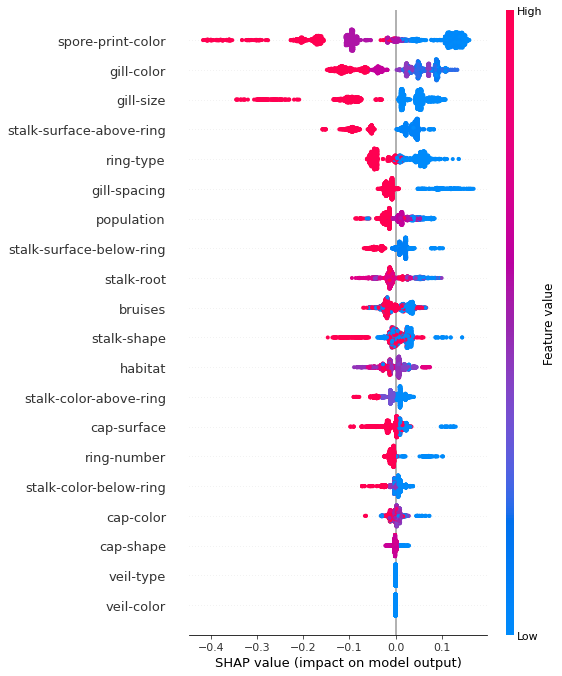

In [76]:
#Negative WoE-features values (blue colour) -there is larger distribution of edibles compared to the poisonous.
#Positive WoE-features values (red colour) -there is larger distribution of poisonous compared to the edibles.
shap_plots(X_test_binned, target_class = 'edible')

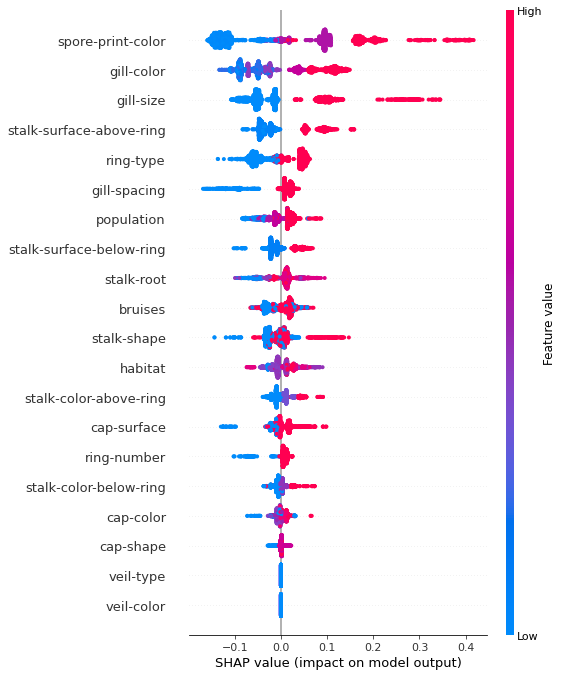

In [77]:
shap_plots(X_test_binned, target_class = 'poisonous')

In [78]:
def cats_indicators(x_set, woe_bins, target_class = 'edible'):
    """
    Function outputs a data frame of variables' categories, which should have implied a target class (based on WoE coefficient).
    """

    if target_class == 'edible':
        filtered_woe_bins = woe_bins[woe_bins['WoE']<= 0]
    elif target_class == 'poisonous':
        filtered_woe_bins = woe_bins[woe_bins['WoE'] >= 0]

    var_cats_dict = {}
    for var in x_set.columns:
        if filtered_woe_bins.loc[filtered_woe_bins['Variable'] == var,'Bin'].shape[0] == 0:
            pass
        else:
            cats_list = []
            for i in filtered_woe_bins.loc[filtered_woe_bins['Variable'] == var,'Bin']:
                for j in i.tolist():
                    cats_list.append(j)
            var_cats_dict[var] = ', '.join(cats_list)

    return pd.DataFrame(var_cats_dict.items(), columns=['Features', 'Categories'])

In [79]:
cats_indicators(X_train, woe_bins, 'edible')

,Features,Categories
0,cap-shape,"convex, bell, sunken"
1,cap-surface,fibrous
2,cap-color,"brown, gray, white, cinnamon, green, purple"
3,bruises,bruises
4,gill-spacing,crowded
5,gill-size,broad
6,gill-color,"pink, yellow, white, black, brown, purple, orange, red"
7,stalk-shape,tapering
8,stalk-root,"equal, club, rooted"
9,stalk-surface-above-ring,"smooth, scaly, fibrous"


In [80]:
cats_indicators(X_train, woe_bins, 'poisonous')

,Features,Categories
0,cap-shape,"conical, knobbed, flat"
1,cap-surface,"grooves, smooth, scaly"
2,cap-color,"buff, yellow, red, pink"
3,bruises,no
4,odor,"creosote, fishy, foul, musty, pungent, spicy, none, almond, anise"
5,gill-attachment,"free, attached"
6,gill-spacing,close
7,gill-size,narrow
8,gill-color,"buff, green, chocolate, gray"
9,stalk-shape,"Ee, enlarging"


Bayesian Optimization - TBD

In [81]:
def bayesian_opt(model, x_train, y_train):

    seed = 702
    models_opt_dict = {}
    
    if model == RandomForestClassifier:

        def model_cv(max_depth, max_features, n_estimators):
            params_gbm = {}
            params_gbm['max_depth'] = round(max_depth)
            params_gbm['max_features'] = max_features
            params_gbm['n_estimators'] = round(n_estimators)

            scores = cross_val_score(model(random_state=123, **params_gbm),
                             x_train, y_train, scoring = 'f1', cv=10).mean()
            return scores


        params ={
            'max_depth':(3, 10),
            'max_features':(0.8, 1),
            'n_estimators':(80, 150)}


    # Run Bayesian Optimization
    bo = BayesianOptimization(model_cv, params, random_state=seed)
    bo.maximize(init_points=20, n_iter=4)

    opt_params = bo.max['params']
    opt_params['n_estimators'] =  round(opt_params['n_estimators'])
    opt_params['max_depth'] = round(opt_params['max_depth'])
    opt_params['max_features'] = round(opt_params['max_features'])

    model_opt = model(**opt_params)
    model_opt.fit(X_train_binned,y_train)
    return model_opt

In [82]:
temp = bayesian_opt(RandomForestClassifier, X_train_binned,y_train)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.9916   |  4.083    |  0.8599   |  134.9    |
|  2        |  1.0      |  8.787    |  0.8405   |  143.8    |
|  3        |  0.9921   |  4.12     |  0.8354   |  149.1    |
|  4        |  1.0      |  9.586    |  0.9643   |  85.87    |
|  5        |  1.0      |  7.515    |  0.9757   |  81.22    |
|  6        |  0.9805   |  3.301    |  0.8672   |  88.26    |
|  7        |  1.0      |  7.831    |  0.9147   |  134.4    |
|  8        |  1.0      |  9.8      |  0.8304   |  98.2     |
|  9        |  1.0      |  7.751    |  0.8483   |  117.4    |
|  10       |  0.9909   |  3.553    |  0.8617   |  90.57    |
|  11       |  0.9909   |  4.27     |  0.9021   |  84.51    |
|  12       |  1.0      |  6.494    |  0.8928   |  91.97    |
|  13       |  1.0      |  7.972    |  0.9725   |  126.2    |
|  14       |  0.9909   |  4.467    |  0.8656   |  123.5    |
|  15   

In [85]:
temp

RandomForestClassifier(max_depth=9, max_features=1, n_estimators=144)

In [84]:
evaluation_metrics_df(X_test_binned,y_test,temp,['Precision','Recall','F1','AUC','Gini','KS','Brier'])

,Metric,Score
0,Precision,1.00000
1,Recall,1.00000
2,F1,1.00000
3,AUC,1.00000
4,Gini,1.00000
5,KS,1.00000
6,Brier,0.00353
